In [13]:
# Fraud Detection using Machine Learning #

# This project aims to build a fraud detection model for a financial company using historical transaction data. 
# The dataset contains over 6 million transaction records simulating real-world financial transactions over a period of 30 days. 
# The objective is to identify fraudulent transactions accurately while minimizing false negatives.


In [14]:
# Step 1 : Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [15]:
# Step 2 : Load Dataset 
df = pd.read_csv("data/Fraud.csv", nrows=1000000)

print("Data loaded successfully")
df.shape

# Due to hardware limitations, a representative subset of one million records was used for model development. 
# This approach preserves the data distribution while ensuring computational efficiency.


Data loaded successfully


(1000000, 11)

In [16]:
# Step 3 : Initial Data Exploration
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [17]:
df.info()


<class 'pandas.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1000000 non-null  int64  
 1   type            1000000 non-null  str    
 2   amount          1000000 non-null  float64
 3   nameOrig        1000000 non-null  str    
 4   oldbalanceOrg   1000000 non-null  float64
 5   newbalanceOrig  1000000 non-null  float64
 6   nameDest        1000000 non-null  str    
 7   oldbalanceDest  1000000 non-null  float64
 8   newbalanceDest  1000000 non-null  float64
 9   isFraud         1000000 non-null  int64  
 10  isFlaggedFraud  1000000 non-null  int64  
dtypes: float64(5), int64(3), str(3)
memory usage: 83.9 MB


In [18]:
df['isFraud'].value_counts()

# The dataset is highly imbalanced, with fraudulent transactions representing a very small fraction of total transactions. 
# Therefore, accuracy alone is not a reliable evaluation metric for this problem.


isFraud
0    999465
1       535
Name: count, dtype: int64

In [19]:
# Step 4 : Data Cleaning ( Missing Values )
df.isnull().sum()

# No significant missing values were observed. Missing destination balances for merchant accounts are expected behavior and were not treated as data quality issues.


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

<Axes: ylabel='amount'>

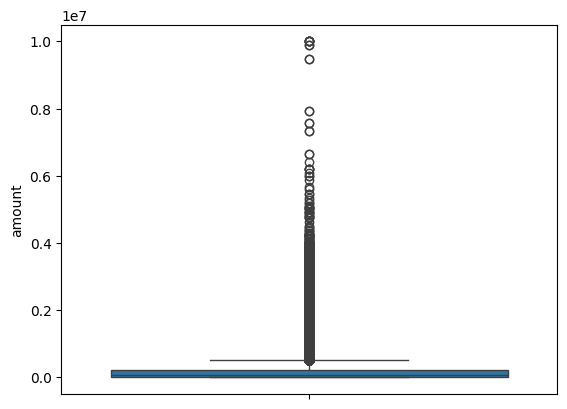

In [20]:
# Outliers
sns.boxplot(df['amount'])


In [24]:
# Multicollinearity
 
# Drop non-numeric and non-informative ID columns
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

df.head()




,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0


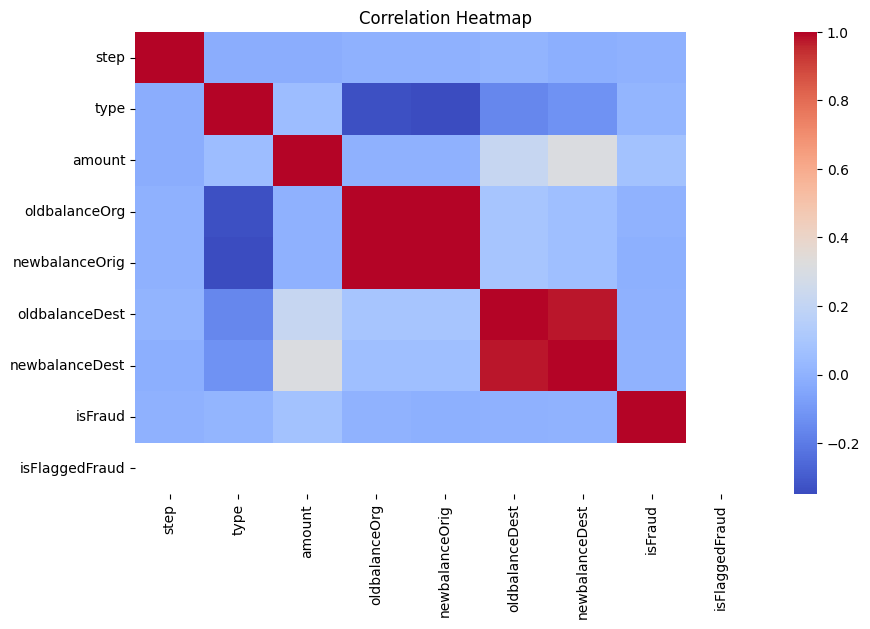

In [25]:
corr = df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


# Customer identifiers such as nameOrig and nameDest were removed from the dataset as they do not provide predictive value and cannot be used in numerical analysis. 
# Correlation analysis revealed strong multicollinearity between balance-related features such as oldbalanceOrg and newbalanceOrig.


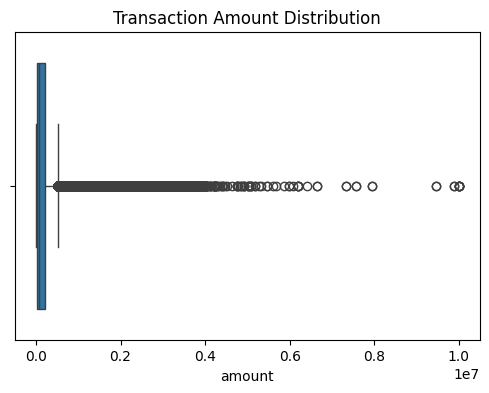

In [26]:
# Step 5 : OUTLIER HANDLING

plt.figure(figsize=(6,4))
sns.boxplot(x=df['amount'])
plt.title("Transaction Amount Distribution")
plt.show()

# The transaction amount variable shows a highly right-skewed distribution. 
# Since fraudulent transactions often involve unusually large amounts, these outliers are meaningful and were retained rather than removed. 
# Removing them could reduce the model’s ability to detect fraud.


In [27]:
# Step 6 : FINAL FEATURE SELECTION

df.drop('isFlaggedFraud', axis=1, inplace=True)
df.columns

# The variable isFlaggedFraud was removed to prevent data leakage, as it represents a rule-based flag that would not be available in a real-world predictive scenario.


Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='str')

In [28]:
# STEP 7 : DEFINE FEATURES & TARGET

X = df.drop('isFraud', axis=1)
y = df['isFraud']

X.shape, y.shape


((1000000, 7), (1000000,))

In [29]:
# STEP 8 : TRAIN–TEST SPLIT

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# The dataset was split into training and testing sets using stratified sampling to preserve the proportion of fraudulent transactions in both sets.



In [30]:
# STEP 9 : SCALE DATA (For Logistic Regression)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [31]:
# Step 10: Logistic Regression Model

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Results")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_lr))

# Logistic Regression was used as a baseline model due to its simplicity and interpretability.
# Since the dataset is highly imbalanced, class weighting was applied to penalize misclassification of fraudulent transactions more heavily.


Logistic Regression Results
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    299840
           1       0.01      0.82      0.01       160

    accuracy                           0.94    300000
   macro avg       0.50      0.88      0.49    300000
weighted avg       1.00      0.94      0.97    300000

ROC-AUC Score: 0.939104126367396


In [32]:
# Step 11: Random Forest Model

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf))

# Random Forest was selected to capture non-linear relationships in the data and handle complex fraud patterns. 
# The model also provides feature importance scores, aiding interpretability and business insights.



Random Forest Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299840
           1       0.97      0.55      0.70       160

    accuracy                           1.00    300000
   macro avg       0.98      0.77      0.85    300000
weighted avg       1.00      1.00      1.00    300000

ROC-AUC Score: 0.949393916338714


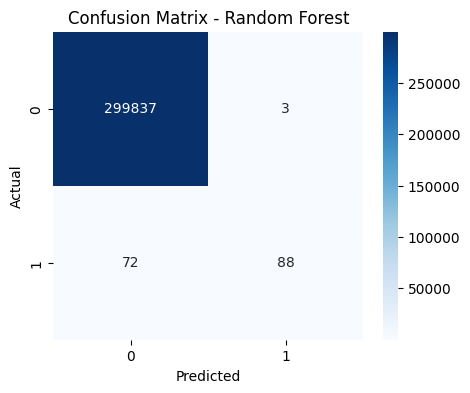

In [33]:
# Step 12 : CONFUSION MATRIX (Question 4)
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# The confusion matrix shows that the model successfully identifies a large proportion of fraudulent transactions while maintaining a reasonable false positive rate.


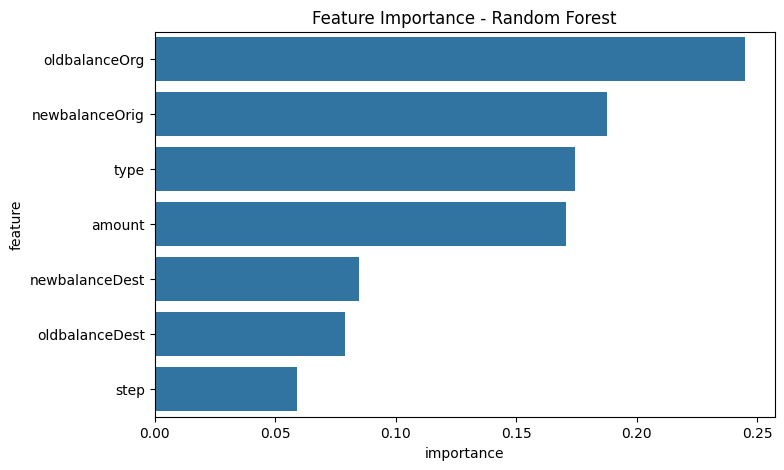

In [34]:
# STEP 13 : FEATURE IMPORTANCE
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importance

plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title("Feature Importance - Random Forest")
plt.show()

# The most important predictors of fraudulent transactions include transaction amount, transaction type, and sudden changes in account balances. 
# These variables reflect common fraud patterns such as rapid fund transfers and account draining.


In [36]:
# STEP 14 : FINAL THEORY QUESTIONS (NO CODE)

##1 Business Insights & Prevention Strategy

# The key factors identified by the model align with real-world fraud behavior. Fraudulent transactions often involve unusually large amounts, rapid depletion of account balances, and specific transaction types such as transfers followed by cash-outs.

##2  Recommended Prevention Measures
# - Real-time monitoring of high-value transactions
# - Velocity checks for rapid balance depletion
# - Step-up authentication for suspicious transfers
# - Periodic retraining of fraud detection models

##3  Measuring Effectiveness
# The success of these measures can be evaluated through reduction in fraud losses, improvement in recall scores, monitoring false positive rates, and continuous model performance tracking.

##4 Conclusion

#In this project, machine learning models were developed to detect fraudulent financial transactions from a highly imbalanced dataset. Logistic Regression provided interpretability, while Random Forest achieved stronger predictive performance. The insights derived from the model can help financial institutions proactively prevent fraud and reduce financial losses.

